#Prepare data for input

## Setting 1: define data parameters

In [ ]:
######################################
# setting 1: define data parameters
######################################

desired_pipeline = 'cpac'
desired_strategy = 'filt_global'
desired_derivative = 'rois_cc400'
download_data_dir = '/content/drive/MyDrive/abide'
desired_age_max = 200.0
desired_age_min = -1.0
desired_site = None
desired_sex = None
desired_diagnosis = 'both'
test_to_total_ratio = 0.1 # desired ratio of test data to all data

In [ ]:
# calculate some needed variables

data_main_path = download_data_dir  + '/'  'Outputs' + '/' + desired_pipeline + '/' + desired_strategy + '/' + desired_derivative
corr_matrix_path = data_main_path + '.pkl'

In [ ]:
#connect to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# install and load needed libraries

!pip install PyPrind
import pandas as pd
import numpy as np
import os
import pyprind
import numpy.ma as ma
import pickle

## Define helper functions

In [ ]:
# this part of code is from https://github.com/preprocessed-connectomes-project/abide
# for more info use this link to original repo


# download_abide_preproc.py
#
# Author: Daniel Clark, 2015
# Updated to python 3 and to support downloading by DX, Cameron Craddock, 2019

"""
This script downloads data from the Preprocessed Connetomes Project's
ABIDE Preprocessed data release and stores the files in a local
directory; users specify derivative, pipeline, strategy, and optionally
age ranges, sex, site of interest

Usage:
    python download_abide_preproc.py -d <derivative> -p <pipeline>
                                     -s <strategy> -o <out_dir>
                                     [-lt <less_than>] [-gt <greater_than>]
                                     [-x <sex>] [-t <site>]
"""


# Main collect and download function
def collect_and_download(derivative, pipeline, strategy, out_dir, less_than, greater_than, site, sex, diagnosis):
    """

    Function to collect and download images from the ABIDE preprocessed
    directory on FCP-INDI's S3 bucket

    Parameters
    ----------
    derivative : string
        derivative or measure of interest
    pipeline : string
        pipeline used to process data of interest
    strategy : string
        noise removal strategy used to process data of interest
    out_dir : string
        filepath to a local directory to save files to
    less_than : float
        upper age (years) threshold for participants of interest
    greater_than : float
        lower age (years) threshold for participants of interest
    site : string
        acquisition site of interest
    sex : string
        'M' or 'F' to indicate whether to download male or female data
    diagnosis : string
        'asd', 'tdc', or 'both' corresponding to the diagnosis of the
        participants for whom data should be downloaded

    Returns
    -------
    None
        this function does not return a value; it downloads data from
        S3 to a local directory

    :param derivative: 
    :param pipeline: 
    :param strategy: 
    :param out_dir: 
    :param less_than: 
    :param greater_than: 
    :param site: 
    :param sex:
    :param diagnosis:
    :return: 
    """

    # Import packages
    import os
    import urllib.request as request

    # Init variables
    mean_fd_thresh = 0.2
    s3_prefix = 'https://s3.amazonaws.com/fcp-indi/data/Projects/'\
                'ABIDE_Initiative'
    s3_pheno_path = '/'.join([s3_prefix, 'Phenotypic_V1_0b_preprocessed1.csv'])

    # Format input arguments to be lower case, if not already
    derivative = derivative.lower()
    pipeline = pipeline.lower()
    strategy = strategy.lower()

    # Check derivative for extension
    if 'roi' in derivative:
        extension = '.1D'
    else:
        extension = '.nii.gz'

    # If output path doesn't exist, create it
    if not os.path.exists(out_dir):
        print('Could not find {0}, creating now...'.format(out_dir))
        os.makedirs(out_dir)

    # Load the phenotype file from S3
    s3_pheno_file = request.urlopen(s3_pheno_path)
    pheno_list = s3_pheno_file.readlines()
    print(pheno_list[0])

    # Get header indices
    header = pheno_list[0].decode().split(',')
    try:
        site_idx = header.index('SITE_ID')
        file_idx = header.index('FILE_ID')
        age_idx = header.index('AGE_AT_SCAN')
        sex_idx = header.index('SEX')
        dx_idx = header.index('DX_GROUP')
        mean_fd_idx = header.index('func_mean_fd')
    except Exception as exc:
        err_msg = 'Unable to extract header information from the pheno file: {0}\nHeader should have pheno info:' \
                  ' {1}\nError: {2}'.format(s3_pheno_path, str(header), exc)
        raise Exception(err_msg)

    # Go through pheno file and build download paths
    print('Collecting images of interest...')
    s3_paths = []
    for pheno_row in pheno_list[1:]:

        # Comma separate the row
        cs_row = pheno_row.decode().split(',')

        try:
            # See if it was preprocessed
            row_file_id = cs_row[file_idx]
            # Read in participant info
            row_site = cs_row[site_idx]
            row_age = float(cs_row[age_idx])
            row_sex = cs_row[sex_idx]
            row_dx = cs_row[dx_idx]
            row_mean_fd = float(cs_row[mean_fd_idx])
        except Exception as e:
            err_msg = 'Error extracting info from phenotypic file, skipping...'
            print(err_msg)
            continue

        # If the filename isn't specified, skip
        if row_file_id == 'no_filename':
            continue
        # If mean fd is too large, skip
        if row_mean_fd >= mean_fd_thresh:
            continue

        # Test phenotypic criteria (three if's looks cleaner than one long if)
        # Test sex
        if (sex == 'M' and row_sex != '1') or (sex == 'F' and row_sex != '2'):
            continue

        if (diagnosis == 'asd' and row_dx != '1') or (diagnosis == 'tdc' and row_dx != '2'):
            continue

        # Test site
        if site is not None and site.lower() != row_site.lower():
            continue
        # Test age range
        if greater_than < row_age < less_than:
            filename = row_file_id + '_' + derivative + extension
            s3_path = '/'.join([s3_prefix, 'Outputs', pipeline, strategy, derivative, filename])
            print('Adding {0} to download queue...'.format(s3_path))
            s3_paths.append(s3_path)
        else:
            continue

    # And download the items
    total_num_files = len(s3_paths)
    for path_idx, s3_path in enumerate(s3_paths):
        rel_path = s3_path.lstrip(s3_prefix)
        download_file = os.path.join(out_dir, rel_path)
        download_dir = os.path.dirname(download_file)
        if not os.path.exists(download_dir):
            os.makedirs(download_dir)
        try:
            if not os.path.exists(download_file):
                print('Retrieving: {0}'.format(download_file))
                request.urlretrieve(s3_path, download_file)
                print('{0:3f}% percent complete'.format(100*(float(path_idx+1)/total_num_files)))
            else:
                print('File {0} already exists, skipping...'.format(download_file))
        except Exception as exc:
            print('There was a problem downloading {0}.\n Check input arguments and try again.'.format(s3_path))

    # Print all done
    print('Done!')


# Make module executable
# if __name__ == '__main__':

#     # Import packages
#     import argparse
#     import os
#     import sys

#     # Init argument parser
#     parser = argparse.ArgumentParser(description=__doc__)

#     # Required arguments
#     parser.add_argument('-a', '--asd', required=False, default=False, action='store_true',
#                         help='Only download data for participants with ASD.'
#                              ' Specifying neither or both -a and -c will download data from all participants.')
#     parser.add_argument('-c', '--tdc', required=False, default=False, action='store_true',
#                         help='Only download data for participants who are typically developing controls.'
#                              ' Specifying neither or both -a and -c will download data from all participants.')
#     parser.add_argument('-d', '--derivative', nargs=1, required=True, type=str,
#                         help='Derivative of interest (e.g. \'reho\')')
#     parser.add_argument('-p', '--pipeline', nargs=1, required=True, type=str,
#                         help='Pipeline used to preprocess the data (e.g. \'cpac\')')
#     parser.add_argument('-s', '--strategy', nargs=1, required=True, type=str,
#                         help='Noise-removal strategy used during preprocessing (e.g. \'nofilt_noglobal\'')
#     parser.add_argument('-o', '--out_dir', nargs=1, required=True, type=str,
#                         help='Path to local folder to download files to')

#     # Optional arguments
#     parser.add_argument('-lt', '--less_than', nargs=1, required=False,
#                         type=float, help='Upper age threshold (in years) of participants to download (e.g. for '
#                                          'subjects 30 or younger, \'-lt 31\')')
#     parser.add_argument('-gt', '--greater_than', nargs=1, required=False,
#                         type=int, help='Lower age threshold (in years) of participants to download (e.g. for '
#                                        'subjects 31 or older, \'-gt 30\')')
#     parser.add_argument('-t', '--site', nargs=1, required=False, type=str,
#                         help='Site of interest to download from (e.g. \'Caltech\'')
#     parser.add_argument('-x', '--sex', nargs=1, required=False, type=str,
#                         help='Participant sex of interest to download only (e.g. \'M\' or \'F\')')

#     # Parse and gather arguments
#     args = parser.parse_args()

#     # Init variables
#     desired_derivative = args.derivative[0].lower()
#     desired_pipeline = args.pipeline[0].lower()
#     desired_strategy = args.strategy[0].lower()
#     download_data_dir = os.path.abspath(args.out_dir[0])

#     # Try and init optional arguments

#     # for diagnosis if both ASD and TDC flags are set to true or false, we download both
#     desired_diagnosis = ''
#     if args.tdc == args.asd:
#         desired_diagnosis = 'both'
#         print('Downloading data for ASD and TDC participants')
#     elif args.tdc:
#         desired_diagnosis = 'tdc'
#         print('Downloading data for TDC participants')
#     elif args.asd:
#         desired_diagnosis = 'asd'
#         print('Downloading data for ASD participants')

#     try:
#         desired_age_max = args.less_than[0]
#         print('Using upper age threshold of {0:d}...'.format(desired_age_max))
#     except TypeError:
#         desired_age_max = 200.0
#         print('No upper age threshold specified')

#     try:
#         desired_age_min = args.greater_than[0]
#         print('Using lower age threshold of {0:d}...'.format(desired_age_min))
#     except TypeError:
#         desired_age_min = -1.0
#         print('No lower age threshold specified')

#     try:
#         desired_site = args.site[0]
#     except TypeError:
#         desired_site = None
#         print('No site specified, using all sites...')

#     try:
#         desired_sex = args.sex[0].upper()
#         if desired_sex == 'M':
#             print('Downloading only male subjects...')
#         elif desired_sex == 'F':
#             print('Downloading only female subjects...')
#         else:
#             print('Please specify \'M\' or \'F\' for sex and try again')
#             sys.exit()
#     except TypeError:
#         desired_sex = None
#         print('No sex specified, using all sexes...')

#     # Call the collect and download routine
#     collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_age_max,
#                          desired_age_min, desired_site, desired_sex, desired_diagnosis)

In [ ]:
# some helper function

def get_key(filename):
  f_split = filename.split('_')
  if f_split[3] == 'rois':
    key = '_'.join(f_split[0:3]) 
  else:
    key = '_'.join(f_split[0:2])
  return key


def get_label(filename):
  assert (filename in labels)
  return labels[filename]


def get_s_label(filename):
  assert (filename in s_labels)
  return s_labels[filename]


def get_a_label(filename):
  assert (filename in a_labels)
  return a_labels[filename]


def get_corr_data(filename):
  for file in os.listdir(data_main_path):
    if file.startswith(filename):
      df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')
          
  with np.errstate(invalid="ignore"):
    corr = np.nan_to_num(np.corrcoef(df.T))
    mask = np.invert(np.tri(corr.shape[0], k=-1, dtype=bool))
    m = ma.masked_where(mask == 1, mask)
    return ma.masked_where(m, corr).compressed()

## Load or make correlation matrix

In [ ]:
# Load or make correlation matrix

if not os.path.exists(corr_matrix_path):
  if not os.path.exists(data_main_path):
    print('Downloading preprocessed data')
    collect_and_download(desired_derivative, desired_pipeline, desired_strategy, download_data_dir, desired_age_max, desired_age_min, desired_site, desired_sex, desired_diagnosis)
  
  print('Making correlation matrix')
  flist = os.listdir(data_main_path)
  print('there are ' + str(len(flist)) + ' files')

  for f in range(len(flist)):
      flist[f] = get_key(flist[f])
      

  df_labels = pd.read_csv('https://s3.amazonaws.com/fcp-indi/data/Projects/ABIDE_Initiative/Phenotypic_V1_0b_preprocessed1.csv')

  df_labels.DX_GROUP = df_labels.DX_GROUP.map({1: 1, 2:0})
  print('there are ' + str(len(df_labels)) + ' labels')

  labels = {}
  for row in df_labels.iterrows():
      file_id = row[1]['FILE_ID']
      y_label = row[1]['DX_GROUP']
      if file_id == 'no_filename':
          continue
      assert(file_id not in labels)
      labels[file_id] = y_label
  
  s_labels = {}
  for row in df_labels.iterrows():
      file_id = row[1]['FILE_ID']
      sex_label = row[1]['SEX']
      if file_id == 'no_filename':
          continue
      assert(file_id not in s_labels)
      s_labels[file_id] = sex_label

  a_labels = {}
  for row in df_labels.iterrows():
      file_id = row[1]['FILE_ID']
      age_lable = row[1]['AGE_AT_SCAN']
      if file_id == 'no_filename':
          continue
      assert(file_id not in a_labels)
      a_labels[file_id] = age_lable

  #make corr matrix
  pbar=pyprind.ProgBar(len(flist))
  all_corr = {}
  for f in flist:
    lab = get_label(f)
    s_lab = get_s_label(f)
    a_lab = get_a_label(f)
    all_corr[f] = (get_corr_data(f), lab, s_lab, a_lab)
    pbar.update()

  print('Corr-computations finished')
  print('total labels & file: ' + str(len(all_corr)))
  pickle.dump(all_corr, open(corr_matrix_path , 'wb'))
  print('Saving to file finished')
else:
  all_corr = pickle.load(open(corr_matrix_path, 'rb'))

## Make x_train, y_train, x_test and *y_test* as input for NN model

In [ ]:
# Make x_train, y_train, x_test and *y_test* as input for NN model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = []
for x_case_counter in all_corr:
  X.append(list(all_corr[x_case_counter][0]))
X = pd.DataFrame(X)
sc = StandardScaler()
X = sc.fit_transform(X)
Y = []
for y_case_counter in all_corr:
  Y.append(all_corr[y_case_counter][1])
Y = np.asarray(Y)

print('Shape of all data as X: ' + str(np.shape(X)))
print('Shape of all data as Y: ' + str(np.shape(Y)))

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_to_total_ratio)

print('Shape of x_train: ' + str(np.shape(x_train)))
print('Shape of y_train: ' + str(np.shape(y_train)))
print('Shape of x_test: ' + str(np.shape(x_test)))
print('Shape of y_test: ' + str(np.shape(y_test)))

input_X_dimension = np.shape(x_train)[1]
print('input X dimension: ' + str(input_X_dimension))

Shape of all data as X: (884, 76636)
Shape of all data as Y: (884,)
Shape of x_train: (795, 76636)
Shape of y_train: (795,)
Shape of x_test: (89, 76636)
Shape of y_test: (89,)
input X dimension: 76636


# Model

## Setting 2: Make model


In [ ]:
#make a model

import keras
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense

input_X_dimension

classifier = Sequential()
classifier.add(Dense(8, activation='relu', kernel_initializer='random_normal', input_dim = input_X_dimension))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')
classifier.summary()

classifier.compile(optimizer ='adam',loss=loss_fn, metrics =['accuracy'])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 613096    
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 613,105
Trainable params: 613,105
Non-trainable params: 0
_________________________________________________________________


## Setting 3: fit model

Epoch 1/20
20/20 [==============================] - 1s 33ms/step - loss: 0.2606 - accuracy: 0.5834 - val_loss: 0.1958 - val_accuracy: 0.6517
Epoch 2/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0789 - accuracy: 0.9115 - val_loss: 0.2140 - val_accuracy: 0.7079
Epoch 3/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0246 - accuracy: 0.9789 - val_loss: 0.2227 - val_accuracy: 0.6742
Epoch 4/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0103 - accuracy: 0.9829 - val_loss: 0.2259 - val_accuracy: 0.6854
Epoch 5/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0078 - accuracy: 0.9861 - val_loss: 0.2294 - val_accuracy: 0.6854
Epoch 6/20
20/20 [==============================] - 0s 20ms/step - loss: 0.0049 - accuracy: 0.9895 - val_loss: 0.2311 - val_accuracy: 0.6629
Epoch 7/20
20/20 [==============================] - 0s 21ms/step - loss: 0.0053 - accuracy: 0.9919 - val_loss: 0.2303 - val_accuracy: 0.6517
Epoch 8/20
20

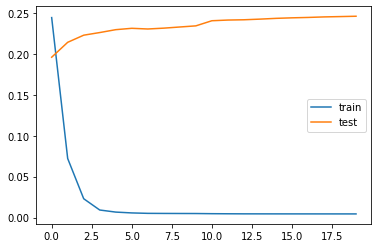

In [ ]:
#fit model

accuracy = []
F1 = []
history = classifier.fit(x_train,y_train, batch_size=40, epochs= 20 , validation_data = (x_test, y_test))

import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
S = []
for ll in rest:
  S.append(rest[ll][2])
S = np.asarray(S)

A = []
for nn in rest:
  A.append(rest[nn][3])
A = np.asarray(A)

print(np.shape(S))
print(np.shape(A))

(88,)
(88,)


In [ ]:
Men = {}
Women = {}
for item in rest:
  if(rest[item][2] == 1):
    Men[item] = rest[item]
  else:
    Women[item] = rest[item]

In [ ]:
len(Women)
# Men

In [ ]:
Xmen = []
for ff in Men:
  Xmen.append(list(Men[ff][0]))
Xmen = pd.DataFrame(Xmen)
sc = StandardScaler()
Xmen = sc.fit_transform(Xmen)
Ymen = []
for jj in Men:
  Ymen.append(Men[jj][1])
Ymen = np.asarray(Ymen)

In [ ]:
np.shape(Ymen)

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred=classifier.predict(Xmen)

y_pred = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(Ymen, y_pred)
accuracy.append((cm[0][0] + cm[1][1])/sum(sum(cm)))
precision = cm[0][0]/(cm[0][0] + cm[1][1])
recall =  cm[0][0]/(cm[0][0] + cm[1][0])
F1.append(2 * precision * recall / (precision + recall))

print('accuracy =', np.mean(accuracy))
print('F1 =', np.mean(F1))

In [ ]:
#calculate accuracy & f1 in test dataset
y_pred=classifier.predict(x_test)

y_pred = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_pred)
accuracy.append((cm[0][0] + cm[1][1])/sum(sum(cm)))
precision = cm[0][0]/(cm[0][0] + cm[1][1])
recall =  cm[0][0]/(cm[0][0] + cm[1][0])
F1.append(2 * precision * recall / (precision + recall))

print('accuracy =', np.mean(accuracy))
print('F1 =', np.mean(F1))

In [ ]:
#get weights from model
for layer in classifier.layers:
    weights = layer.get_weights() # list of numpy arrays

# calculate normal-autistic corr-diff

In [ ]:
#divide whole collection to normal and autistic
normals = {}
autistic = {}
for item in all_corr:
  if(all_corr[item][1] == 0):
    normals[item] = all_corr[item]
  else:
    autistic[item] = all_corr[item]

In [ ]:
#sum over nomal
sum_n = np.zeros(19900)
for item_n in normals:
  sum_n = sum_n + normals[item_n][0]

#sum over autistic
sum_a = np.zeros(19900)
for item_a in autistic:
  sum_a = sum_a + autistic[item_a][0]

print(np.shape(sum_n))

In [ ]:
#make diff matrix
diff = sum_n - sum_a
print(np.shape(diff))
print(sum_n)

In [ ]:
#add index to diff matrix
num_diff = []
for counter in range(len(diff)):
  num_diff = num_diff + [[counter ,diff[counter]]]

print(num_diff)

In [ ]:
#sort diff matrix
arr = np.array(num_diff)
sorted_diff = arr[arr[:,1].argsort()]

In [ ]:
#make a mask from first and last 1000 elements
mask1 = sorted_diff[0:1000,0]
mask2 = sorted_diff[-1000:,0]
mask = np.concatenate((mask1, mask2))
mask = mask.astype('int32')
print(mask)

In [ ]:
# apply mask to data
masked_diff = np.array(num_diff)[mask.astype(int)]
print(masked_diff)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

X = []
for ff in all_corr:
  tempx = all_corr[ff][0]
  masked_tempx = np.array(tempx)[mask.astype(int)]
  X.append(list(masked_tempx))
X = pd.DataFrame(X)
sc = StandardScaler()
X = sc.fit_transform(X)
Y = []
for jj in all_corr:
  Y.append(all_corr[jj][1])
Y = np.asarray(Y)

print(np.shape(X))
print(np.shape(Y))

In [ ]:
import keras
classifier = Sequential()
classifier.add(Dense(100, activation='relu', kernel_initializer='random_normal', input_dim=2000))
classifier.add(Dense(4, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

classifier.compile(optimizer ='adam',loss=loss_fn, metrics =['accuracy'])

accuracy = []
F1 = []
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.10)

In [ ]:
classifier.fit(x_train,y_train, batch_size = 40, epochs = 100)
y_pred=classifier.predict(x_test)

y_pred = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_pred)
accuracy.append((cm[0][0] + cm[1][1])/sum(sum(cm)))
precision = cm[0][0]/(cm[0][0] + cm[1][1])
recall =  cm[0][0]/(cm[0][0] + cm[1][0])
F1.append(2 * precision * recall / (precision + recall))

print('accuracy =', np.mean(accuracy))
print('F1 =', np.mean(F1))

In [ ]:
y_pred = np.where(y_pred > 0.5, 1, 0)

cm = confusion_matrix(y_test, y_pred)
accuracy.append((cm[0][0] + cm[1][1])/sum(sum(cm)))
precision = cm[0][0]/(cm[0][0] + cm[1][1])
recall =  cm[0][0]/(cm[0][0] + cm[1][0])
F1.append(2 * precision * recall / (precision + recall))

print('accuracy =', np.mean(accuracy))
print('F1 =', np.mean(F1))

In [ ]:
print(cm)